In [116]:
# importando bibliotecas que serão usadas.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import nltk

In [60]:
# Lendo o arquivo .csv
caminho = "https://raw.githubusercontent.com/manipulaeHealth/desafio-machine-learning/main/dados_preco.csv"
data = pd.read_csv(caminho)

data.head()

,descricao,criado,qtdInsumos,calculado,correto
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,2020-08-05 23:19:09,1,47.5297,39.9
1,60 CAP | FINASTERIDA 1:10 1MG,2020-08-05 22:51:09,1,46.9620,43.6
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,2020-08-05 22:51:09,3,105.1390,111.4
3,60 CAP | ANASTROZOL 1:10 0.300MG,2020-08-05 22:51:09,1,49.0314,43.6
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2020-08-05 22:49:09,2,161.8272,146.0


In [3]:
data.describe()

,qtdInsumos,calculado,correto
count,7121.000000,7121.000000,7121.000000
mean,3.281842,137.089552,135.891798
std,3.194301,191.266516,189.806974
min,1.000000,30.000100,33.000000
25%,1.000000,49.786100,49.500000
50%,2.000000,87.350300,83.100000
75%,4.000000,165.167000,161.200000
max,26.000000,10364.992500,10356.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   descricao   7121 non-null   object 
 1   criado      7121 non-null   object 
 2   qtdInsumos  7121 non-null   int64  
 3   calculado   7121 non-null   float64
 4   correto     7121 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 278.3+ KB


In [5]:
df = pd.DataFrame()

In [6]:
df = data[['descricao', 'qtdInsumos', 'calculado', 'correto']].copy()
df.shape

(7121, 4)

In [7]:
# Criando uma coluna no df que representa a quantidade de capsulas
lst = []
qtd_cap = []
for descricao in df.descricao:
    lst = descricao.split(" ")
    qtd_cap.append(lst[0])

df["qtd_cap"] = qtd_cap
df['qtd_cap'] = pd.to_numeric(df["qtd_cap"], downcast="float")
df.head()

,descricao,qtdInsumos,calculado,correto,qtd_cap
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,1,47.5297,39.9,30.0
1,60 CAP | FINASTERIDA 1:10 1MG,1,46.9620,43.6,60.0
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,3,105.1390,111.4,60.0
3,60 CAP | ANASTROZOL 1:10 0.300MG,1,49.0314,43.6,60.0
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2,161.8272,146.0,120.0


In [8]:
# Criando uma lista de componentes separada por ;
lst_componentes=[]
for s in df['descricao']:
    
    # Remover pontuações (exceto ;)
    s=re.sub(r'[^\w\s;]','',s)
    
    #Remove Units
    s=re.sub(r"(\d\w*)", "", s)
    
    #Remove Digits
    s=re.sub(r"(\d)", "", s)
    
    #Remove content inside paranthesis
    s=re.sub(r'\([^)]*\)', '', s)
    
    #Convert to lowercase
    s=s.lower()
    
    #Remove 'cap', 'mg':
    s=re.sub(r"cap", "", s)
    
    #Remover espaços duplos
    s=re.sub(r"(\s\s\s)", " ", s)
    s=re.sub(r"(\s\s)", " ", s)
    s=re.sub(r"  ", "5htp", s)
    
    #Remover espaços no início e final das palavras
    
    lst_componentes.append(s)
df['componentes'] = lst_componentes
lst_componentes

[' bupropiona cloridrato ',
 ' finasterida ',
 ' nac ; silimarina ; same ',
 ' anastrozol ',
 ' dutasterida ; tadalafil ',
 ' triiodotironina slow release ',
 ' t ',
 ' vitamina b ; vitamina b ; vitamina b ; vitamina b ; acido folico ; zinco quelado ; vitamina b ; selenio quelado ; magnesio quelado ; picolinato de cromo ; saw palmeto ext seco ; espironolactona ; pygeum africanum ext seco ; finasterida ',
 ' cortisol ; prasterona ',
 ' tadalafil ; arginina ',
 ' gestrinona ',
 ' magnesio quelado ; coenzima q po ',
 ' silimarina ; vitamina b ; vitamina b ; acido folico ; nac ',
 ' vitamina d ; vitamina k mk ',
 ' oxandrolona ',
 ' bupropiona cloridrato ',
 ' triiodotironina slow release ',
 ' clomifeno citrato ; tadalafil ',
 ' t ',
 ' coenzima q po ; magnesio quelado ',
 ' vitamina d ',
 ' citrus aurantium ext seco ; camelia sinensis ; sicum annuum ; zingiber officinalis l roscoe ; cafeina base anidra ',
 ' vitamina d liq ate ; vitamina a oleosa oral ; vitamina k liq sol mae ',
 ' magne

In [9]:
# verificando quantos componentes únicos existem
lst = []
componentes_unicos = set()

for words in lst_componentes:
    lst = words.split(";")
    for item in lst:
        componentes_unicos.add(item.strip())
len(componentes_unicos)

1501

In [10]:
# Criando uma coluna 'qtd' que representa a quantia dos componentes, separada por ;
lst_quantidade=[]
s=[]
for s in df['descricao']:
    
    # Remover Valor das capsulas
    sliced = s[3:]
    
    # Remover proporções
    s = re.sub(r'\d:\d\d', '', sliced)
    
    # Remover pontuações (exceto ; e .)
    s=re.sub(r'[^\d;.]','',s)
    
    #Remove content inside paranthesis
    s=re.sub(r'\([^)]*\)', '', s)
    
    lst_quantidade.append(s)
df['qtd'] = lst_quantidade
lst_quantidade

['150',
 '1',
 '250;150;50',
 '0.300',
 '0.250;10',
 '12',
 '460',
 '230;360;570;630;3;30;1260;200;30400;1000;200;100;.100;0.500',
 '20;20',
 '10;2',
 '2',
 '30200;10100',
 '200;12300;6100;2.500;200',
 '10000;27100',
 '20',
 '150',
 '10',
 '100;5',
 '450',
 '10100;30200',
 '304000',
 '200;400;6;.200;100',
 '155000;1000;2100',
 '400',
 '100;500;60;10000;2000;20;30;400;10;0.500;50;400',
 '300',
 '550',
 '300',
 '34000',
 '120',
 '500',
 '30;20;2;2.500',
 '30200',
 '40.00010000',
 '3;8.700;50',
 '100',
 '1;5',
 '4',
 '500',
 '100;100',
 '300',
 '300;200;20',
 '200;38;39',
 '25',
 '60',
 '120',
 '600',
 '157000;2100',
 '240;50',
 '200;150;200;300',
 '400',
 '1',
 '3008',
 '30',
 '30',
 '250',
 '4000;27100',
 '5',
 '500',
 '200;50;50;25;510;200;200;100;10;50;150',
 '100;50;30;50;100;200',
 '350000',
 '100;300;200;50',
 '200',
 '156000',
 '250',
 '500',
 '100;100;200;100',
 '250',
 '600;5;1.200;1.300;16;5;61.300;30;240;122.400;45;10;14;7;130;50',
 '1510000',
 '125',
 '5',
 '150;150',
 '25',


In [11]:
# Criando um dicionário que tenha o componente como chave e a quantidade como valor
lst_comp = []
for i in lst_componentes:
    lst_comp.append(i.split(';'))
    
lst_qtd = []
for i in lst_quantidade:
    lst_qtd.append(i.split(';'))

dict_comp_qtd = [dict(zip(*z)) for z in zip(lst_comp, lst_qtd)]
  
print(dict_comp_qtd)

[{' bupropiona cloridrato ': '150'}, {' finasterida ': '1'}, {' nac ': '250', ' silimarina ': '150', ' same ': '50'}, {' anastrozol ': '0.300'}, {' dutasterida ': '0.250', ' tadalafil ': '10'}, {' triiodotironina slow release ': '12'}, {' t ': '460'}, {' vitamina b ': '1260', ' acido folico ': '3', ' zinco quelado ': '30', ' selenio quelado ': '200', ' magnesio quelado ': '30400', ' picolinato de cromo ': '1000', ' saw palmeto ext seco ': '200', ' espironolactona ': '100', ' pygeum africanum ext seco ': '.100', ' finasterida ': '0.500'}, {' cortisol ': '20', ' prasterona ': '20'}, {' tadalafil ': '10', ' arginina ': '2'}, {' gestrinona ': '2'}, {' magnesio quelado ': '30200', ' coenzima q po ': '10100'}, {' silimarina ': '200', ' vitamina b ': '6100', ' acido folico ': '2.500', ' nac ': '200'}, {' vitamina d ': '10000', ' vitamina k mk ': '27100'}, {' oxandrolona ': '20'}, {' bupropiona cloridrato ': '150'}, {' triiodotironina slow release ': '10'}, {' clomifeno citrato ': '100', ' tad

In [12]:
df1 = pd.DataFrame(dict_comp_qtd)
df1 = df1.apply(pd.to_numeric, errors='coerce')
df1 = df1.fillna(0)
df1.head(20)

,bupropiona cloridrato,finasterida,nac,silimarina,same,anastrozol,dutasterida,tadalafil,triiodotironina slow release,t,...,glicerina,aloe vera ext glicolico,pcana,gentamicina sulfato,base creme,dlfenilalanina,bacteroides fragilis,andarine,lprolina,trimetilxantina microensula
0,150.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,250.0,150.0,50.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.3,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.25,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,12.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,460.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.5,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.00,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
dff = pd.concat([df, df1], axis=1, join='inner')
dff.head()

,descricao,qtdInsumos,calculado,correto,qtd_cap,componentes,qtd,bupropiona cloridrato,finasterida,nac,...,glicerina,aloe vera ext glicolico,pcana,gentamicina sulfato,base creme,dlfenilalanina,bacteroides fragilis,andarine,lprolina,trimetilxantina microensula
0,30 CAP | BUPROPIONA CLORIDRATO 150MG,1,47.5297,39.9,30.0,bupropiona cloridrato,150,150.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,60 CAP | FINASTERIDA 1:10 1MG,1,46.9620,43.6,60.0,finasterida,1,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,60 CAP | NAC 250MG; SILIMARINA 150MG; SAME ...,3,105.1390,111.4,60.0,nac ; silimarina ; same,250;150;50,0.0,0.0,250.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,60 CAP | ANASTROZOL 1:10 0.300MG,1,49.0314,43.6,60.0,anastrozol,0.300,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,120 CAP | DUTASTERIDA 0.250MG; TADALAFIL 10MG,2,161.8272,146.0,120.0,dutasterida ; tadalafil,0.250;10,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
dff = dff.drop(['descricao'],axis=1)
dff = dff.drop(['componentes'],axis=1)
dff = dff.drop(['calculado'],axis=1)
dff = dff.drop(['qtd'],axis=1)
dff = dff.drop(['qtdInsumos'],axis=1)

KeyError: "['descricao'] not found in axis"

In [74]:
dff.columns

Index(['correto', 'qtd_cap', ' bupropiona cloridrato ', ' finasterida ',
       ' nac ', ' silimarina ', ' same ', ' anastrozol ', ' dutasterida ',
       ' tadalafil ',
       ...
       ' glicerina ', ' aloe vera ext glicolico ', ' pcana ',
       ' gentamicina sulfato ', ' base creme ', ' dlfenilalanina ',
       ' bacteroides fragilis ', ' andarine ', ' lprolina ',
       ' trimetilxantina microensula '],
      dtype='object', length=1503)

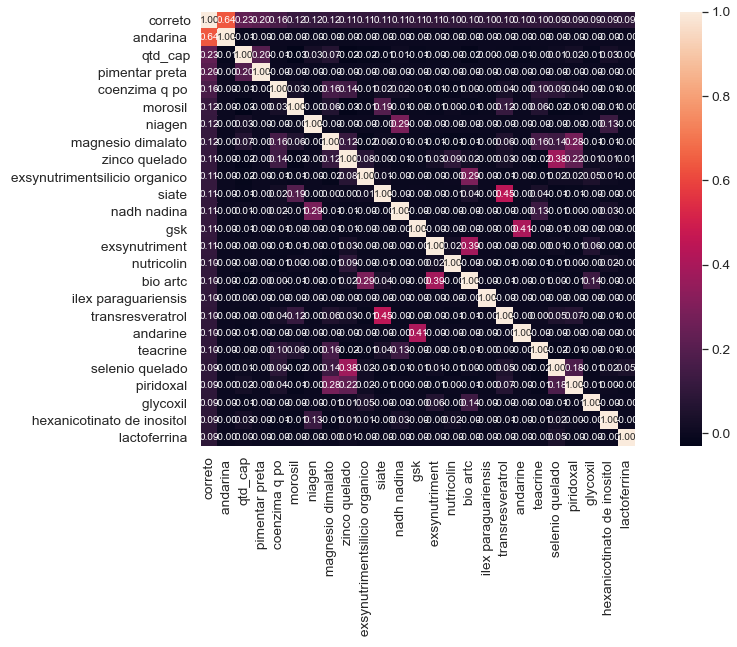

In [15]:
#saleprice correlation matrix
k = 25 #number of variables for heatmap
plt.figure(figsize=(16,8))
corrmat = dff.corr()
# picking the top 15 correlated features
cols = corrmat.nlargest(k, 'correto')['correto'].index
cm = np.corrcoef(dff[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Train/Test Split

In [167]:
X = dff.drop(['correto'],axis=1)
y = (dff['correto'])

# scaling = MinMaxScaler()
# scaling.fit_transform(X)
# scaling.fit_transform(y)

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Linear Regression

In [223]:
# we are going to scale to data

# y_train= y_train.values.reshape(-1,1)
# y_test= y_test.values.reshape(-1,1)

# sc_X = StandardScaler()
# sc_y = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.fit_transform(X_test)
# y_train = sc_X.fit_transform(y_train)
# y_test = sc_y.fit_transform(y_test)

In [224]:
X_train

,qtd_cap,bupropiona cloridrato,finasterida,nac,silimarina,same,anastrozol,dutasterida,tadalafil,triiodotironina slow release,...,glicerina,aloe vera ext glicolico,pcana,gentamicina sulfato,base creme,dlfenilalanina,bacteroides fragilis,andarine,lprolina,trimetilxantina microensula
4818,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6054,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2081,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3091,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5695,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1361,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1547,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [225]:
lm = LinearRegression()

lm.fit(X_train,y_train)
print(lm)

LinearRegression()


In [226]:
predictions = lm.predict(X_test)
predictions= predictions.reshape(-1,1)

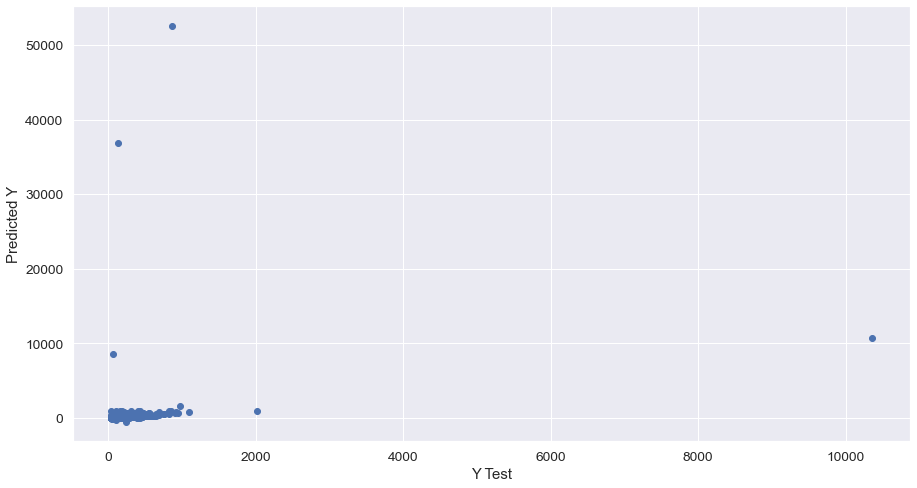

In [227]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

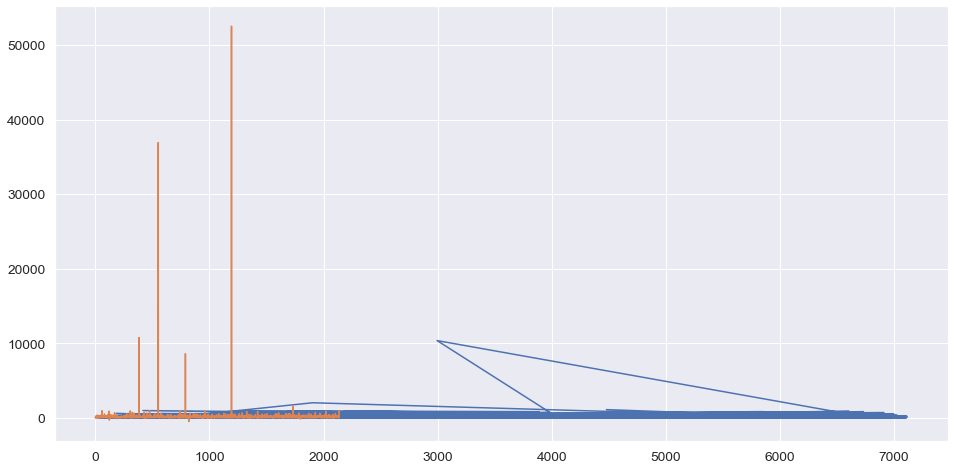

In [228]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(predictions, label = 'predict')
plt.show()

In [229]:
def r2_ajustado(y_test, predictions):
    adj_r2 = (1 - ((1 - r2_score(y_test, predictions)) * (len(y_test) - 1)) / 
    (len(y_test) - X_train.shape[1] - 1))
    return adj_r2


print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2 score', r2_score(y_test, predictions))
print('R2 ajustado', r2_ajustado(y_test, predictions))

MAE: 96.72102462874066
MSE: 1926358.2754835894
RMSE: 1387.933094743255
R2 score -28.23197112097443
R2 ajustado -97.48500049590123


# Gradien Boosting Regression

In [230]:
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.05, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4)

In [231]:
clf_pred=clf.predict(X_test)
clf_pred= clf_pred.reshape(-1,1)

In [232]:
print('MAE:', metrics.mean_absolute_error(y_test, clf_pred))
print('MSE:', metrics.mean_squared_error(y_test, clf_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, clf_pred)))
print('R2 score:', r2_score(y_test, clf_pred))
print('R2 ajustado', r2_ajustado(y_test, clf_pred))

MAE: 71.64336534878517
MSE: 60736.350048498876
RMSE: 246.44745900191157
R2 score: 0.07834214787204685
R2 ajustado -2.1051438046455964


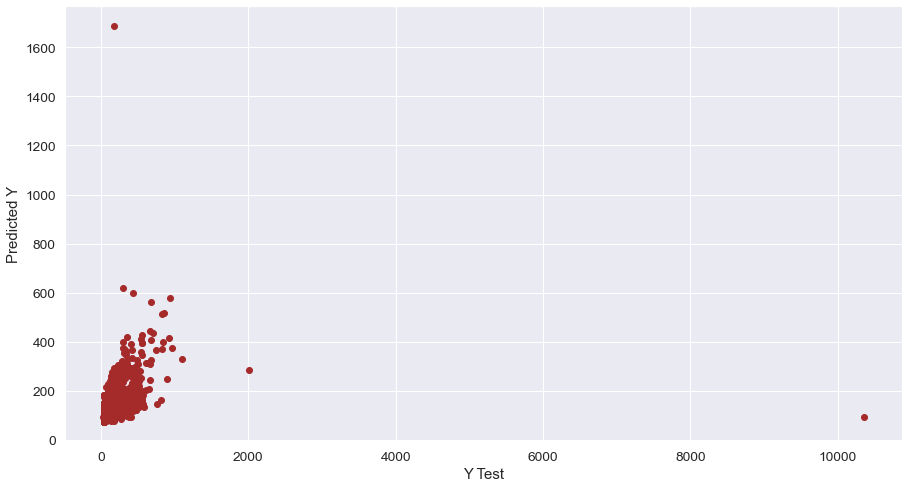

In [233]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,clf_pred, c= 'brown')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

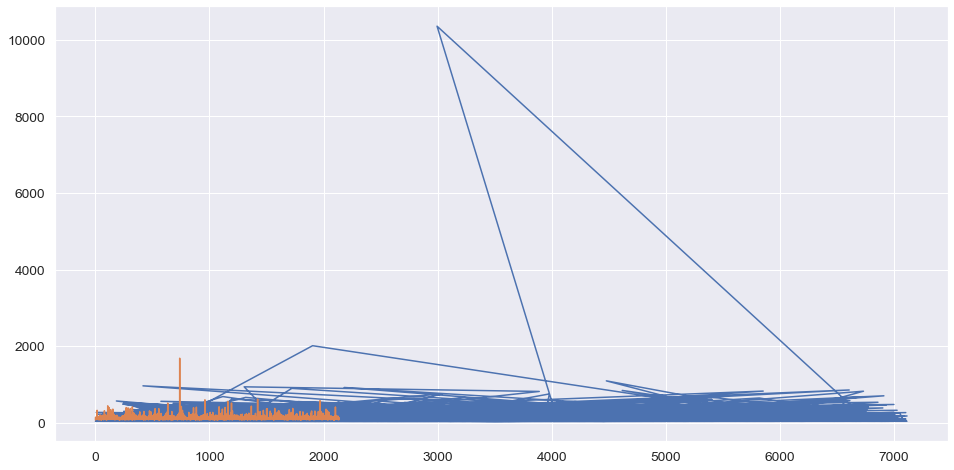

In [234]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(clf_pred, label = 'predict')
plt.show()

# Decison Tree Regression

In [235]:
dtreg = DecisionTreeRegressor(random_state = 100)
dtreg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=100)

In [236]:
dtr_pred = dtreg.predict(X_test)
dtr_pred= dtr_pred.reshape(-1,1)

In [237]:
print('MAE:', metrics.mean_absolute_error(y_test, dtr_pred))
print('MSE:', metrics.mean_squared_error(y_test, dtr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)))
print('R2 score', r2_score(y_test, dtr_pred))
print('R2 ajustado', r2_ajustado(y_test, dtr_pred))

MAE: 59.27511386679146
MSE: 65438.28410733244
RMSE: 255.809077452956
R2 score 0.006991557294058648
R2 ajustado -2.3455300214824777


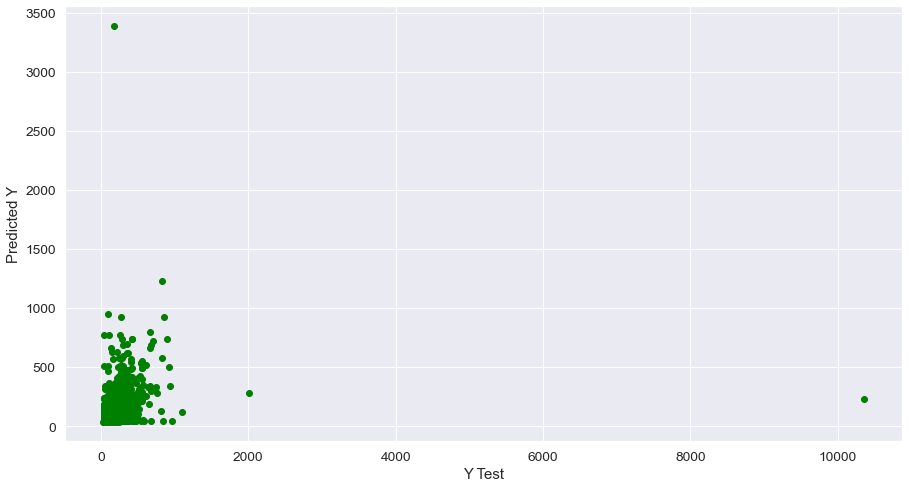

In [238]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,dtr_pred,c='green')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

# Support Vector Machine Regression

In [239]:
svr = SVR(kernel = 'rbf')
svr.fit(X_train, y_train)

SVR()

In [240]:
svr_pred = svr.predict(X_test)
svr_pred= svr_pred.reshape(-1,1)

In [241]:
print('MAE:', metrics.mean_absolute_error(y_test, svr_pred))
print('MSE:', metrics.mean_squared_error(y_test, svr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, svr_pred)))
print('R2 score', r2_score(y_test, svr_pred))
print('R2 ajustado', r2_ajustado(y_test, svr_pred))

MAE: 81.833774268788
MSE: 68481.71115054021
RMSE: 261.69010518271455
R2 score -0.03919163332426412
R2 ajustado -2.501125124259666


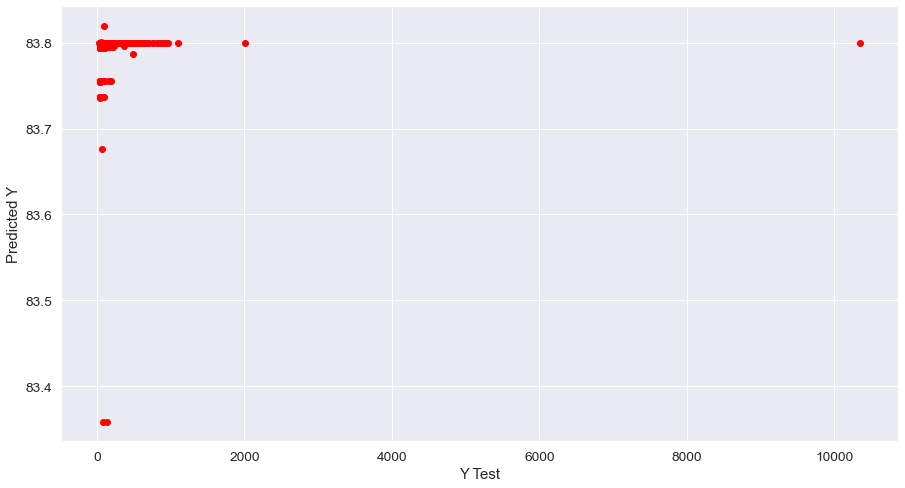

In [242]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,svr_pred, c='red')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

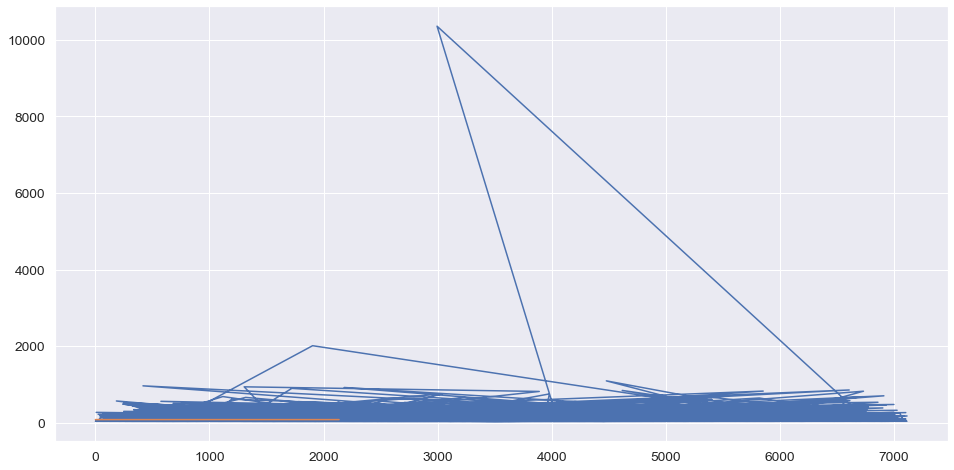

In [243]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(svr_pred, label = 'predict')
plt.show()

# Random Forest Regressor

In [ ]:
rfr = RandomForestRegressor(n_estimators = 100, random_state = 0)
rfr.fit(X_train, y_train)

In [ ]:
rfr_pred= rfr.predict(X_test)
rfr_pred = rfr_pred.reshape(-1,1)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, rfr_pred))
print('MSE:', metrics.mean_squared_error(y_test, rfr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)))
print('R2 score', r2_score(y_test, rfr_pred))
print('R2 ajustado', r2_ajustado(y_test, rfr_pred))

In [ ]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,rfr_pred, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(rfr_pred, label = 'predict')
plt.show()


# LightGBM

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.1, n_estimators=500,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
model_lgb.fit(X_train,y_train)

In [ ]:
lgb_pred = model_lgb.predict(X_test)
lgb_pred = lgb_pred.reshape(-1,1)

In [ ]:
print('MAE:', metrics.mean_absolute_error(y_test, lgb_pred))
print('MSE:', metrics.mean_squared_error(y_test, lgb_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lgb_pred)))
print('R2 score', r2_score(y_test, lgb_pred))
print('R2 ajustado', r2_ajustado(y_test, lgb_pred))

In [ ]:
plt.figure(figsize=(15,8))
plt.scatter(y_test,lgb_pred, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(lgb_pred, label = 'predict')
plt.show()

# Comparação entre os modelos

In [ ]:
error_rate=np.array([metrics.mean_squared_error(y_test, clf_pred), metrics.mean_squared_error(y_test, dtr_pred), metrics.mean_squared_error(y_test, svr_pred), metrics.mean_squared_error(y_test, rfr_pred), metrics.mean_squared_error(y_test, lgb_pred)])

In [ ]:
a = data.copy()
data.columns

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(error_rate)

In [ ]:
# initialise data of lists.
comp = {'MAE':[metrics.mean_absolute_error(y_test, predictions),
               metrics.mean_absolute_error(y_test, clf_pred),
               metrics.mean_absolute_error(y_test, dtr_pred), 
               metrics.mean_absolute_error(y_test, svr_pred),
               metrics.mean_absolute_error(y_test, rfr_pred),
               metrics.mean_absolute_error(y_test, lgb_pred)],
        'MSE':[metrics.mean_squared_error(y_test, predictions),
               metrics.mean_squared_error(y_test, clf_pred),
               metrics.mean_squared_error(y_test, dtr_pred),
               metrics.mean_squared_error(y_test, svr_pred),
               metrics.mean_squared_error(y_test, rfr_pred),
               metrics.mean_squared_error(y_test, lgb_pred)],
       'RMSE':[np.sqrt(metrics.mean_squared_error(y_test, predictions)),
               np.sqrt(metrics.mean_squared_error(y_test, clf_pred)),
               np.sqrt(metrics.mean_squared_error(y_test, dtr_pred)), 
               np.sqrt(metrics.mean_squared_error(y_test, svr_pred)),
               np.sqrt(metrics.mean_squared_error(y_test, rfr_pred)),
               np.sqrt(metrics.mean_squared_error(y_test, lgb_pred))],
   'R2 score':[r2_score(y_test, predictions),
               r2_score(y_test, clf_pred),
               r2_score(y_test, dtr_pred), 
               r2_score(y_test, svr_pred),
               r2_score(y_test, rfr_pred),
               r2_score(y_test, lgb_pred)],
'R2 ajustado':[r2_ajustado(y_test, predictions),
               r2_ajustado(y_test, clf_pred),
               r2_ajustado(y_test, dtr_pred), 
               r2_ajustado(y_test, svr_pred),
               r2_ajustado(y_test, rfr_pred),
               r2_ajustado(y_test, lgb_pred)]}
 
# Creates pandas DataFrame.
comparacao = pd.DataFrame(comp, index =['Regressão Linear',
                                'Gradient Boost',
                                'Decision Tree',
                                'Support Vector Machine',
                                'Random Forest',
                                'LightGBM'])
comparacao

In [ ]:
test_prediction_rl = pd.DataFrame(predictions, columns=['calculado_RL'])
test_prediction_clf = pd.DataFrame(clf_pred, columns=['calculado_Gradient Boost'])
test_prediction_dtr = pd.DataFrame(dtr_pred, columns=['calculado_Decision Tree'])
test_prediction_svr = pd.DataFrame(svr_pred, columns=['calculado_SVM'])
test_prediction_rfr = pd.DataFrame(rfr_pred, columns=['calculado_Random Forest'])
test_prediction_lgb = pd.DataFrame(lgb_pred, columns=['calculado_LightGBM'])

In [ ]:
# Backup com standization e log

# test_prediction_svr =sc_y.inverse_transform(svr_pred)

# test_prediction_svr = pd.DataFrame(test_prediction_svr, columns=['calculado_ivan'])
# test_prediction_svr['calculado_ivan'] = np.exp(test_prediction_svr['calculado_ivan'])


In [ ]:
result = pd.concat([a,test_prediction_rl,test_prediction_clf,test_prediction_dtr,test_prediction_svr,test_prediction_rfr,test_prediction_lgb], axis=1)
result = result.drop(['criado'],axis=1)
result = result.drop(['qtdInsumos'],axis=1)

In [ ]:
result.head(10)